**Utkarsha sathe**

**TASK 7:- Stock Market Prediction using Numerical and Textual Analysis**

In [ ]:
import warnings 
warnings.filterwarnings('ignore')

In [ ]:
import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

In [ ]:
stock_price=pd.read_csv('^BSESN.csv')
stock_headlines=pd.read_csv('india-news-headlines.csv')

In [ ]:
stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-03,41634.511719,41636.179688,41348.679688,41464.609375,41464.609375,8900.0
1,2020-01-06,41378.339844,41378.339844,40613.960938,40676.628906,40676.628906,8700.0
2,2020-01-07,40983.039063,41230.140625,40727.371094,40869.468750,40869.468750,11900.0
3,2020-01-08,40574.828125,40866.359375,40476.550781,40817.738281,40817.738281,18200.0
4,2020-01-09,41216.671875,41482.121094,41175.718750,41452.351563,41452.351563,7800.0


In [ ]:
stock_headlines.head()

,publish_date,headline_category,headline_text
0,20010101,sports.wwe,win over cena satisfying but defeating underta...
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


In [ ]:
len(stock_price), len(stock_headlines)

(250, 3297172)

In [ ]:
stock_price.isna().any(), stock_headlines.isna().any()

(Date         False
 Open          True
 High          True
 Low           True
 Close         True
 Adj Close     True
 Volume        True
 dtype: bool, publish_date         False
 headline_category    False
 headline_text        False
 dtype: bool)

In [ ]:
stock_price=stock_price.drop_duplicates()
stock_price['Date']=pd.to_datetime(stock_price['Date']).dt.normalize()
stock_price=stock_price.filter(['Date','Close','Open','High','Low','Volume'])
stock_price.set_index('Date', inplace=True)
stock_price=stock_price.sort_index(ascending=True, axis=0)
stock_price

,Close,Open,High,Low,Volume
Date,,,,,
2020-01-03,41464.609375,41634.511719,41636.179688,41348.679688,8900.0
2020-01-06,40676.628906,41378.339844,41378.339844,40613.960938,8700.0
2020-01-07,40869.468750,40983.039063,41230.140625,40727.371094,11900.0
2020-01-08,40817.738281,40574.828125,40866.359375,40476.550781,18200.0
2020-01-09,41452.351563,41216.671875,41482.121094,41175.718750,7800.0
...,...,...,...,...,...
2020-12-28,47353.750000,47153.589844,47406.718750,47148.238281,9600.0
2020-12-29,47613.078125,47466.621094,47714.550781,47361.898438,12800.0
2020-12-30,47746.218750,47789.031250,47807.851563,47358.359375,15600.0


In [ ]:
stock_headlines=stock_headlines.drop_duplicates()

stock_headlines['publish_date']=stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date']=stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines['publish_date']=pd.to_datetime(stock_headlines['publish_date']).dt.normalize()

stock_headlines=stock_headlines.filter(['publish_date','headline_text'])

stock_headlines=stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

stock_headlines.set_index('publish_date', inplace=True)
stock_headlines=stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-01,win over cena satisfying but defeating underta...
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
...,...
2020-06-26,Containment zone residents slam high prices ch...
2020-06-27,like me i wont let you have a toxic relationsh...
2020-06-28,Atanu Ghosh plans to rewrite old scripts to ma...


In [ ]:
stock_data=pd.concat([stock_price,stock_headlines], axis=1)

stock_data.dropna(axis=0, inplace=True)
stock_data

,Close,Open,High,Low,Volume,headline_text
2020-01-03,41464.609375,41634.511719,41636.179688,41348.679688,8900.0,"Bank Holidays in 2020,Mazya Navryachi Bayko up..."
2020-01-06,40676.628906,41378.339844,41378.339844,40613.960938,8700.0,With captive pics and posts; city shining on s...
2020-01-07,40869.468750,40983.039063,41230.140625,40727.371094,11900.0,"Pro-CAA campaign in Bettiah turns unruly,Holy ..."
2020-01-08,40817.738281,40574.828125,40866.359375,40476.550781,18200.0,"Seems like systematic assault; say students,Co..."
2020-01-09,41452.351563,41216.671875,41482.121094,41175.718750,7800.0,"Health fix: Quick meals in your mason jar,Dead..."
...,...,...,...,...,...,...
2020-06-24,34868.980469,35679.738281,35706.550781,34794.929688,26600.0,I never thought I had a voice until today: Vid...
2020-06-25,34842.101563,34525.390625,35081.609375,34499.781250,24600.0,Truck firms look for new export markets to sel...
2020-06-26,35171.269531,35144.781250,35254.878906,34910.339844,24800.0,Containment zone residents slam high prices ch...
2020-06-29,34961.519531,34926.949219,35032.359375,34662.058594,18300.0,6 hot and stylish bikini looks of Katrina Kaif...


In [ ]:
stock_data['compound']=''
stock_data['negative']=''
stock_data['neutral']=''
stock_data['positive']=''
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2020-01-03,41464.609375,41634.511719,41636.179688,41348.679688,8900.0,"Bank Holidays in 2020,Mazya Navryachi Bayko up...",,,,
2020-01-06,40676.628906,41378.339844,41378.339844,40613.960938,8700.0,With captive pics and posts; city shining on s...,,,,
2020-01-07,40869.468750,40983.039063,41230.140625,40727.371094,11900.0,"Pro-CAA campaign in Bettiah turns unruly,Holy ...",,,,
2020-01-08,40817.738281,40574.828125,40866.359375,40476.550781,18200.0,"Seems like systematic assault; say students,Co...",,,,
2020-01-09,41452.351563,41216.671875,41482.121094,41175.718750,7800.0,"Health fix: Quick meals in your mason jar,Dead...",,,,


In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

sid=SentimentIntensityAnalyzer()

stock_data['compound']=stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
stock_data['negative']=stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
stock_data['neutral']=stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_data['positive']=stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])

stock_data.head()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2020-01-03,41464.609375,41634.511719,41636.179688,41348.679688,8900.0,"Bank Holidays in 2020,Mazya Navryachi Bayko up...",-0.9956,0.100,0.810,0.090
2020-01-06,40676.628906,41378.339844,41378.339844,40613.960938,8700.0,With captive pics and posts; city shining on s...,-0.9995,0.101,0.844,0.055
2020-01-07,40869.468750,40983.039063,41230.140625,40727.371094,11900.0,"Pro-CAA campaign in Bettiah turns unruly,Holy ...",-1.0000,0.186,0.746,0.068
2020-01-08,40817.738281,40574.828125,40866.359375,40476.550781,18200.0,"Seems like systematic assault; say students,Co...",-0.9999,0.133,0.806,0.061
2020-01-09,41452.351563,41216.671875,41482.121094,41175.718750,7800.0,"Health fix: Quick meals in your mason jar,Dead...",-0.9997,0.129,0.787,0.084


In [ ]:
stock_data.drop(['headline_text'], axis=1, inplace=True)

stock_data=stock_data[['Close','compound','negative','neutral','positive','Open','High','Low','Volume']]

stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2020-01-03,41464.609375,-0.9956,0.100,0.810,0.090,41634.511719,41636.179688,41348.679688,8900.0
2020-01-06,40676.628906,-0.9995,0.101,0.844,0.055,41378.339844,41378.339844,40613.960938,8700.0
2020-01-07,40869.468750,-1.0000,0.186,0.746,0.068,40983.039063,41230.140625,40727.371094,11900.0
2020-01-08,40817.738281,-0.9999,0.133,0.806,0.061,40574.828125,40866.359375,40476.550781,18200.0
2020-01-09,41452.351563,-0.9997,0.129,0.787,0.084,41216.671875,41482.121094,41175.718750,7800.0


In [ ]:
stock_data.to_csv('stock_data.csv')

In [ ]:
stock_data=pd.read_csv('stock_data.csv',index_col=False)
stock_data.rename(columns={'Unnamed: 0':'Date'}, inplace=True)
stock_data.set_index('Date', inplace=True)
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2020-01-03,41464.609375,-0.9956,0.100,0.810,0.090,41634.511719,41636.179688,41348.679688,8900.0
2020-01-06,40676.628906,-0.9995,0.101,0.844,0.055,41378.339844,41378.339844,40613.960938,8700.0
2020-01-07,40869.468750,-1.0000,0.186,0.746,0.068,40983.039063,41230.140625,40727.371094,11900.0
2020-01-08,40817.738281,-0.9999,0.133,0.806,0.061,40574.828125,40866.359375,40476.550781,18200.0
2020-01-09,41452.351563,-0.9997,0.129,0.787,0.084,41216.671875,41482.121094,41175.718750,7800.0


In [ ]:
stock_data.shape

(120, 9)

In [ ]:
stock_data.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [ ]:
stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,35210.214079,-0.999226,0.127158,0.796750,0.076100,35315.758724,35644.614583,34828.448552,21125.000000
std,4689.265152,0.001752,0.023933,0.028711,0.012919,4701.487271,4516.468925,4870.362601,22832.945569
min,25981.240234,-1.000000,0.074000,0.730000,0.045000,26499.810547,27462.869141,25638.900391,5600.000000
25%,31377.442871,-0.999900,0.110000,0.775000,0.067000,31405.696778,31694.087402,30826.115234,11800.000000
50%,34106.509766,-0.999700,0.126500,0.794000,0.076500,34191.980468,34438.964844,33796.214843,18150.000000
75%,40830.670898,-0.999375,0.142250,0.816250,0.086250,41038.374024,41158.880859,40628.223633,22925.000000
max,41952.628906,-0.983700,0.199000,0.869000,0.106000,42263.000000,42273.871094,41850.289063,188300.000000


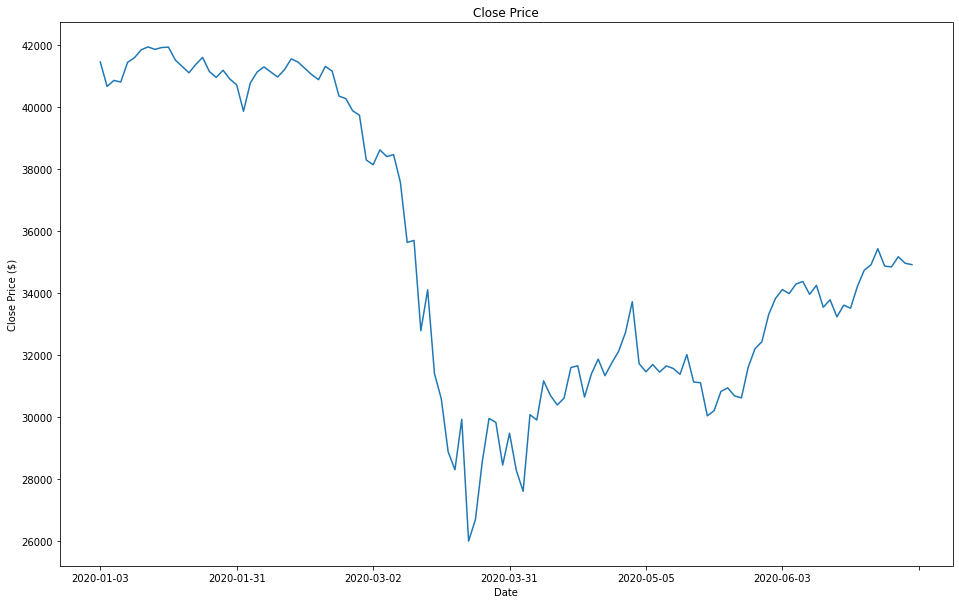

In [ ]:
plt.figure(figsize=(16,10))
stock_data['Close'].plot()

plt.title('Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.show()

In [ ]:
stock_data.rolling(7).mean().head(20)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-13,41248.601004,-0.999200,0.131571,0.796429,0.072000,41306.257255,41466.839844,41072.977679,11328.571429
2020-01-14,41318.318080,-0.999814,0.139857,0.791000,0.069143,41341.768415,41517.994420,41133.294643,12071.428571
2020-01-15,41489.189732,-0.999857,0.145571,0.780571,0.073857,41426.271206,41602.497210,41281.030134,11700.000000


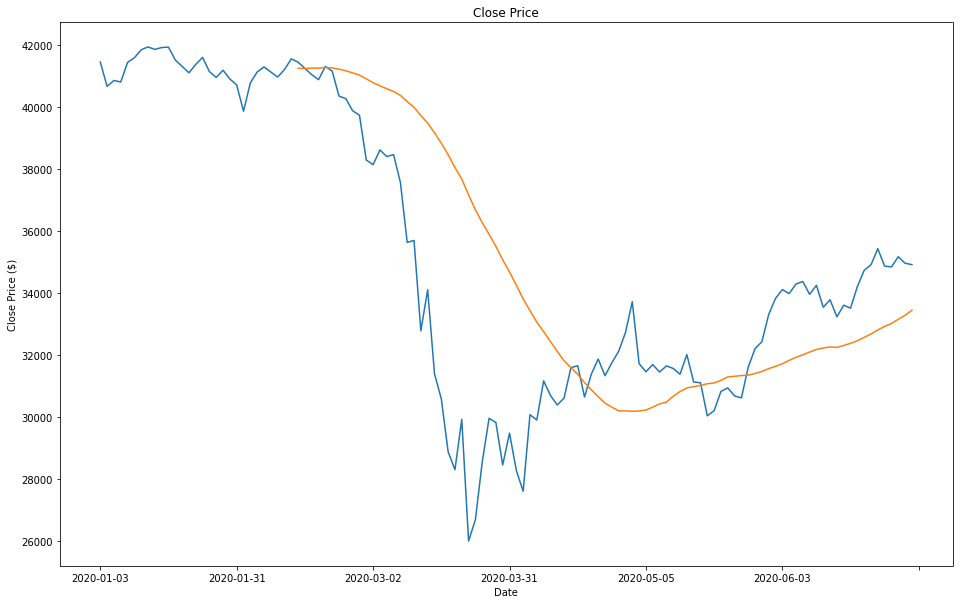

In [ ]:
plt.figure(figsize=(16,10))

stock_data['Close'].plot()
stock_data.rolling(30).mean()['Close'].plot()
plt.title('Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.show()